In [41]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime

from sklearn.model_selection import train_test_split

In [42]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [43]:
train.head(5)

,datetime,datetime_iso,time-zone,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
0,283996800,1979-01-01 00:00:00+00:00,28800,24.75 Celcius,NaN,23.89 C,25.76 C,24.28,25.22°C,1012,undetermined,NaN,95,0.82,320.0 °,zero,0,NaN,NaN,100
1,284000400,1979-01-01 01:00:00+00:00,28800,24.58 C,NaN,23.73 C,25.57 C,23.99 C,25.26 C,1012,NaN,NaN,95,0.96 m/s,338.0°,0,0,0,0,100
2,284004000,1979-01-01 02:00:00+00:00,28800,26.6 Celcius,unidentified,24.06 C,26.6 C,26.1 C,27.39,1012,NaN,undetermined,86,1.22 m/s,339.0°,0,volume:zero,NaN,NaN,99
3,284007600,1979-01-01 03:00:00+00:00,28800,27.31 Celcius,NaN,24.37 C,30.9 C,26.59,28.36 C,1012,NaN,undetermined,84,1.08 m/s,342,0.13,nol,0,NaN,94
4,284011200,1979-01-01 04:00:00+00:00,28800,27.41,NaN,25.05 C,31.54 C,26.58 C,28.31 °C,1011,NaN,undetermined,87,0.86,336.0°,0.34,nol,NaN,0,100


In [44]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341880 entries, 0 to 341879
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   datetime      341880 non-null  int64 
 1   datetime_iso  341880 non-null  object
 2   time-zone     341880 non-null  int64 
 3   temp          341880 non-null  object
 4   visibility    51112 non-null   object
 5   d_point       341880 non-null  object
 6   feels         341880 non-null  object
 7   min_temp      341880 non-null  object
 8   max_temp      341880 non-null  object
 9   prssr         341880 non-null  object
 10  sea_level     192964 non-null  object
 11  grnd_level    192919 non-null  object
 12  hum           341880 non-null  object
 13  wind_spd      341880 non-null  object
 14  wind_deg      341880 non-null  object
 15  rain_1h       341880 non-null  object
 16  rain_3h       192329 non-null  object
 17  snow_1h       192696 non-null  object
 18  snow_3h       192699 non

Masih ada beberapa kolom yang terdeteksi sebagai object, oleh karena itu kita perlu melakukan pre-processing dan juga data cleaning dalam dataset ini.

In [45]:
from modules.data_processing import extract_string
from modules.handle_outliers import remove_outliers_iqr

In [46]:
columns_to_extract = ['temp', 'min_temp', 'max_temp', 'prssr', 'hum', 'wind_spd', 'rain_1h', 'rain_3h', 'snow_1h', 'snow_3h', 'clouds', 'd_point', 'feels', 'wind_deg']

for column in columns_to_extract:
    train[column] = train[column].apply(lambda x: extract_string(x))


In [47]:
def features_engineering(df):
    df['wind_cloud_interaction'] = df['wind_spd'] * df['clouds']
    
    df['avg_temp'] = (df['max_temp'] + df['min_temp']) / 2
    
    return df

In [48]:
train.head(10)

,datetime,datetime_iso,time-zone,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_1h,rain_3h,snow_1h,snow_3h,clouds
0,283996800,1979-01-01 00:00:00+00:00,28800,24.75,NaN,23.89,25.76,24.28,25.22,1012.0,undetermined,NaN,95.0,0.82,320.0,NaN,0.0,NaN,NaN,100.0
1,284000400,1979-01-01 01:00:00+00:00,28800,24.58,NaN,23.73,25.57,23.99,25.26,1012.0,NaN,NaN,95.0,0.96,338.0,0.00,0.0,0.0,0.0,100.0
2,284004000,1979-01-01 02:00:00+00:00,28800,26.60,unidentified,24.06,26.60,26.10,27.39,1012.0,NaN,undetermined,86.0,1.22,339.0,0.00,NaN,NaN,NaN,99.0
3,284007600,1979-01-01 03:00:00+00:00,28800,27.31,NaN,24.37,30.90,26.59,28.36,1012.0,NaN,undetermined,84.0,1.08,342.0,0.13,NaN,0.0,NaN,94.0
4,284011200,1979-01-01 04:00:00+00:00,28800,27.41,NaN,25.05,31.54,26.58,28.31,1011.0,NaN,undetermined,87.0,0.86,336.0,0.34,NaN,NaN,0.0,100.0
5,284014800,1979-01-01 05:00:00+00:00,28800,28.08,NaN,24.92,32.79,27.36,29.40,1010.0,NaN,NaN,83.0,0.84,7.0,3.33,NaN,NaN,NaN,100.0
6,284018400,1979-01-01 06:00:00+00:00,28800,28.68,NaN,24.25,33.29,27.62,31.02,1010.0,undetermined,undetermined,77.0,0.82,309.0,8.01,NaN,NaN,NaN,100.0
7,284022000,1979-01-01 07:00:00+00:00,28800,28.62,NaN,25.85,34.70,28.12,29.35,1010.0,NaN,not recorded,85.0,0.71,291.0,2.54,NaN,NaN,0.0,95.0
8,284025600,1979-01-01 08:00:00+00:00,28800,26.55,NaN,24.21,26.55,26.09,26.83,1009.0,undetermined,undetermined,87.0,0.62,285.0,1.29,0.0,NaN,NaN,97.0
9,284029200,1979-01-01 09:00:00+00:00,28800,26.38,NaN,24.97,26.38,25.68,29.02,1009.0,NaN,undetermined,92.0,0.44,294.0,0.39,0.0,NaN,0.0,92.0


In [49]:
train_selected_column = train[['temp','d_point','feels','min_temp','max_temp','prssr','hum','wind_spd','wind_deg','rain_1h','clouds']]
train_selected_column.head(5)

,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_1h,clouds
0,24.75,23.89,25.76,24.28,25.22,1012.0,95.0,0.82,320.0,NaN,100.0
1,24.58,23.73,25.57,23.99,25.26,1012.0,95.0,0.96,338.0,0.00,100.0
2,26.60,24.06,26.60,26.10,27.39,1012.0,86.0,1.22,339.0,0.00,99.0
3,27.31,24.37,30.90,26.59,28.36,1012.0,84.0,1.08,342.0,0.13,94.0
4,27.41,25.05,31.54,26.58,28.31,1011.0,87.0,0.86,336.0,0.34,100.0


In [50]:
train_filled = train_selected_column.fillna(train_selected_column.mean())
train_filled.isna().sum()

temp        0
d_point     0
feels       0
min_temp    0
max_temp    0
prssr       0
hum         0
wind_spd    0
wind_deg    0
rain_1h     0
clouds      0
dtype: int64

In [51]:
train_filled.head()

,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_1h,clouds
0,24.75,23.89,25.76,24.28,25.22,1012.0,95.0,0.82,320.0,0.401359,100.0
1,24.58,23.73,25.57,23.99,25.26,1012.0,95.0,0.96,338.0,0.000000,100.0
2,26.60,24.06,26.60,26.10,27.39,1012.0,86.0,1.22,339.0,0.000000,99.0
3,27.31,24.37,30.90,26.59,28.36,1012.0,84.0,1.08,342.0,0.130000,94.0
4,27.41,25.05,31.54,26.58,28.31,1011.0,87.0,0.86,336.0,0.340000,100.0


In [52]:
train_filled.shape

(341880, 11)

In [53]:
train_clean = remove_outliers_iqr(train_filled)
train_clean.shape

(223109, 11)

In [54]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range= (0,1))
train_scaled = scaler.fit_transform(train_clean)
scaled_df = pd.DataFrame(train_clean, columns=train_clean.columns)
scaled_df.head()

,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,rain_1h,clouds
0,24.75,23.89,25.76,24.28,25.22,1012.0,95.0,0.82,320.0,0.401359,100.0
1,24.58,23.73,25.57,23.99,25.26,1012.0,95.0,0.96,338.0,0.000000,100.0
2,26.60,24.06,26.60,26.10,27.39,1012.0,86.0,1.22,339.0,0.000000,99.0
3,27.31,24.37,30.90,26.59,28.36,1012.0,84.0,1.08,342.0,0.130000,94.0
4,27.41,25.05,31.54,26.58,28.31,1011.0,87.0,0.86,336.0,0.340000,100.0


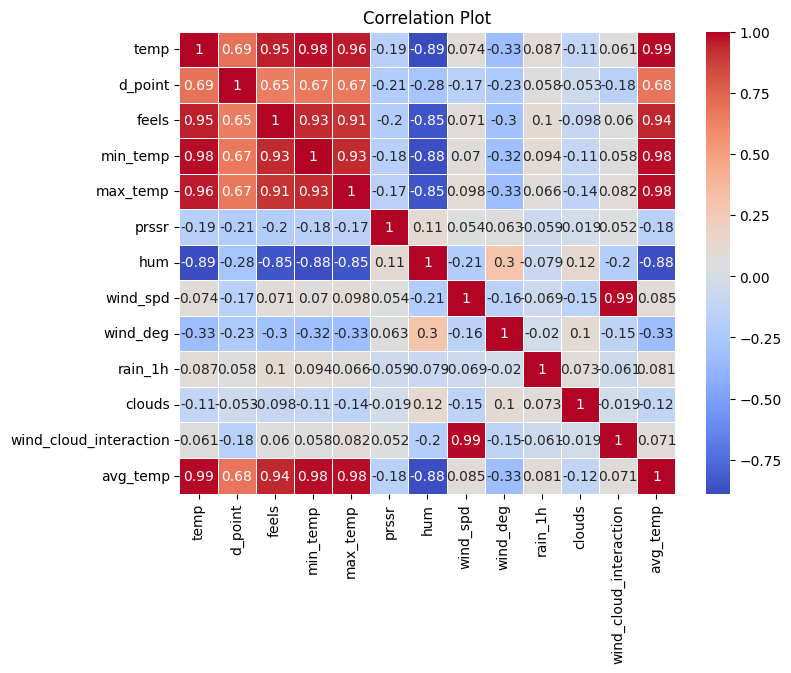

In [86]:
# Calculate the correlation matrix
correlation_matrix = scaled_df.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Plot')
plt.show()

In [40]:
selected_X = scaled_df[['feels', 'clouds', 'prssr']]
X = scaled_df.drop('rain_1h', axis = 1)
y = scaled_df['rain_1h']

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [57]:
X_train.columns

Index(['temp', 'd_point', 'feels', 'min_temp', 'max_temp', 'prssr', 'hum',
       'wind_spd', 'wind_deg', 'clouds', 'wind_cloud_interaction', 'avg_temp'],
      dtype='object')

In [46]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=0, max_features = "sqrt")

# Fit the model to the data
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

In [47]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE: ", rmse)

RMSE:  0.24350735877901286


# Test

In [48]:
# test.head()

,datetime,datetime_iso,time-zone,temp,visibility,d_point,feels,min_temp,max_temp,prssr,sea_level,grnd_level,hum,wind_spd,wind_deg,rain_3h,snow_1h,snow_3h,clouds
0,1514764800,2018-01-01 00:00:00+00:00,28800,26.59 °C,NaN,23.66,26.59,26.02,27.16,1009,NaN,undetermined,84,1.45 m/s,355,0,NaN,no_snow,97
1,1514768400,2018-01-01 01:00:00+00:00,28800,26.51 C,NaN,24.92,26.51 °C,26.06,28.04,1009,NaN,undetermined,91,1.67 m/s,351,0mm,no-snow,0 milimeter,95
2,1514772000,2018-01-01 02:00:00+00:00,28800,28.68 C,NaN,25.71,34.68,28.03 C,29.3 C,1009.0 hPa.,NaN,NaN,84,1.72 m/s,345.0°,0 mm,volume:zero,0,90
3,1514775600,2018-01-01 03:00:00+00:00,28800,28.84 C,NaN,25.25,34.51,28.52,29.08 °C,1008,NaN,NaN,81,1.49,339.0°,0 milimeter,0,NaN,91
4,1514779200,2018-01-01 04:00:00+00:00,28800,29.75 Celcius,,24.62,35.38,29.31 C,30.57,1007,undetermined,undetermined,74,1.39 m/s,339.0°,NaN,0,volume:0,96


In [58]:
# test_selected_column = test[['datetime_iso','temp','d_point','feels','min_temp','max_temp','prssr','hum','wind_spd','wind_deg','clouds']]
# test_selected_column.head(5)

,datetime_iso,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,clouds
0,2018-01-01 00:00:00+00:00,26.59,23.66,26.59,26.02,27.16,1009.0,84.0,1.45,355.0,97.0
1,2018-01-01 01:00:00+00:00,26.51,24.92,26.51,26.06,28.04,1009.0,91.0,1.67,351.0,95.0
2,2018-01-01 02:00:00+00:00,28.68,25.71,34.68,28.03,29.30,1009.0,84.0,1.72,345.0,90.0
3,2018-01-01 03:00:00+00:00,28.84,25.25,34.51,28.52,29.08,1008.0,81.0,1.49,339.0,91.0
4,2018-01-01 04:00:00+00:00,29.75,24.62,35.38,29.31,30.57,1007.0,74.0,1.39,339.0,96.0


In [53]:
# test_selected_column['temp'] = test_selected_column['temp'].apply(lambda x: extract_string(x))
# test_selected_column['min_temp'] = test_selected_column['min_temp'].apply(lambda x: extract_string(x))
# test_selected_column['max_temp'] = test_selected_column['max_temp'].apply(lambda x: extract_string(x))
# test_selected_column['prssr'] = test_selected_column['prssr'].apply(lambda x: extract_string(x))
# test_selected_column['hum'] = test_selected_column['hum'].apply(lambda x: extract_string(x))
# test_selected_column['wind_spd'] = test_selected_column['wind_spd'].apply(lambda x: extract_string(x))
# test_selected_column['clouds'] = test_selected_column['clouds'].apply(lambda x: extract_string(x))
# test_selected_column['d_point'] = test_selected_column['d_point'].apply(lambda x: extract_string(x))
# test_selected_column['feels'] = test_selected_column['feels'].apply(lambda x: extract_string(x))
# test_selected_column['wind_deg'] = test_selected_column['wind_deg'].apply(lambda x: extract_string(x))


C:\Users\MSI GL65\AppData\Local\Temp\ipykernel_6032\3348821507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_selected_column['temp'] = test_selected_column['temp'].apply(lambda x: extract_string(x))
C:\Users\MSI GL65\AppData\Local\Temp\ipykernel_6032\3348821507.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_selected_column['min_temp'] = test_selected_column['min_temp'].apply(lambda x: extract_string(x))
C:\Users\MSI GL65\AppData\Local\Temp\ipykernel_6032\3348821507.py:3: SettingWithCopy

In [59]:
# test_selected_column.head()

,datetime_iso,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,clouds
0,2018-01-01 00:00:00+00:00,26.59,23.66,26.59,26.02,27.16,1009.0,84.0,1.45,355.0,97.0
1,2018-01-01 01:00:00+00:00,26.51,24.92,26.51,26.06,28.04,1009.0,91.0,1.67,351.0,95.0
2,2018-01-01 02:00:00+00:00,28.68,25.71,34.68,28.03,29.30,1009.0,84.0,1.72,345.0,90.0
3,2018-01-01 03:00:00+00:00,28.84,25.25,34.51,28.52,29.08,1008.0,81.0,1.49,339.0,91.0
4,2018-01-01 04:00:00+00:00,29.75,24.62,35.38,29.31,30.57,1007.0,74.0,1.39,339.0,96.0


In [61]:
# test_selected_column['wind_cloud_interaction'] = test_selected_column['wind_spd'] * test_selected_column['clouds']
# test_selected_column['avg_temp'] = (test_selected_column['min_temp'] + test_selected_column['max_temp']) / 2
# test_selected_column.head()

C:\Users\MSI GL65\AppData\Local\Temp\ipykernel_6032\1734354441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_selected_column['wind_cloud_interaction'] = test_selected_column['wind_spd'] * test_selected_column['clouds']
C:\Users\MSI GL65\AppData\Local\Temp\ipykernel_6032\1734354441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_selected_column['avg_temp'] = (test_selected_column['min_temp'] + test_selected_column['max_temp']) / 2


,datetime_iso,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,clouds,wind_cloud_interaction,avg_temp
0,2018-01-01 00:00:00+00:00,26.59,23.66,26.59,26.02,27.16,1009.0,84.0,1.45,355.0,97.0,140.65,26.590
1,2018-01-01 01:00:00+00:00,26.51,24.92,26.51,26.06,28.04,1009.0,91.0,1.67,351.0,95.0,158.65,27.050
2,2018-01-01 02:00:00+00:00,28.68,25.71,34.68,28.03,29.30,1009.0,84.0,1.72,345.0,90.0,154.80,28.665
3,2018-01-01 03:00:00+00:00,28.84,25.25,34.51,28.52,29.08,1008.0,81.0,1.49,339.0,91.0,135.59,28.800
4,2018-01-01 04:00:00+00:00,29.75,24.62,35.38,29.31,30.57,1007.0,74.0,1.39,339.0,96.0,133.44,29.940


In [62]:
# test_selected_column.head()

,datetime_iso,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,clouds,wind_cloud_interaction,avg_temp
0,2018-01-01 00:00:00+00:00,26.59,23.66,26.59,26.02,27.16,1009.0,84.0,1.45,355.0,97.0,140.65,26.590
1,2018-01-01 01:00:00+00:00,26.51,24.92,26.51,26.06,28.04,1009.0,91.0,1.67,351.0,95.0,158.65,27.050
2,2018-01-01 02:00:00+00:00,28.68,25.71,34.68,28.03,29.30,1009.0,84.0,1.72,345.0,90.0,154.80,28.665
3,2018-01-01 03:00:00+00:00,28.84,25.25,34.51,28.52,29.08,1008.0,81.0,1.49,339.0,91.0,135.59,28.800
4,2018-01-01 04:00:00+00:00,29.75,24.62,35.38,29.31,30.57,1007.0,74.0,1.39,339.0,96.0,133.44,29.940


In [69]:
# X_test_sub = X_test_sub.fillna(X_test_sub.mean())
# X_test_sub.isna().sum()

temp                      0
d_point                   0
feels                     0
min_temp                  0
max_temp                  0
prssr                     0
hum                       0
wind_spd                  0
wind_deg                  0
clouds                    0
wind_cloud_interaction    0
avg_temp                  0
dtype: int64

In [72]:
# test_scaled = scaler.fit_transform(X_test_sub)
# scaled_df_test = pd.DataFrame(test_scaled, columns=X_test_sub.columns)
# scaled_df_test.head()

,temp,d_point,feels,min_temp,max_temp,prssr,hum,wind_spd,wind_deg,clouds,wind_cloud_interaction,avg_temp
0,0.000415,0.453057,0.000325,0.000599,0.015764,0.992358,0.84,0.000145,0.986111,0.97,0.000141,0.000789
1,0.000407,0.590611,0.000317,0.000603,0.019285,0.992358,0.91,0.000167,0.975000,0.95,0.000159,0.000879
2,0.000624,0.676856,0.001135,0.000801,0.024327,0.992358,0.84,0.000172,0.958333,0.90,0.000155,0.001195
3,0.000641,0.626638,0.001118,0.000850,0.023447,0.991266,0.81,0.000149,0.941667,0.91,0.000136,0.001221
4,0.000732,0.557860,0.001205,0.000929,0.029408,0.990175,0.74,0.000139,0.941667,0.96,0.000133,0.001444


In [73]:
# predictions = rf_model.predict(scaled_df_test)

# print(predictions)

[0.38554077 0.32863591 0.39446309 ... 0.27196309 0.27196309 0.34519514]


In [79]:
# submission = pd.DataFrame({
#     'datetime_iso': test_selected_column['datetime_iso'],
#     'rain_1h': predictions
# })

# submission.to_csv('data/sample_submission.csv', index=False)